# Image Manipulation using Generative Adversarial Networks

## 1 - Implementation

### 1.1- Data Selection and Exploration

We are using only 8,000 images from COCO dataset for training and 2000 images for validation, So our training set size is 0.6% of what was used in the paper Image-to-Image translation with Conditional Adversarial Networks.

In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/cn')

In [5]:
path = '/content/drive/MyDrive/cn/train2017'

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


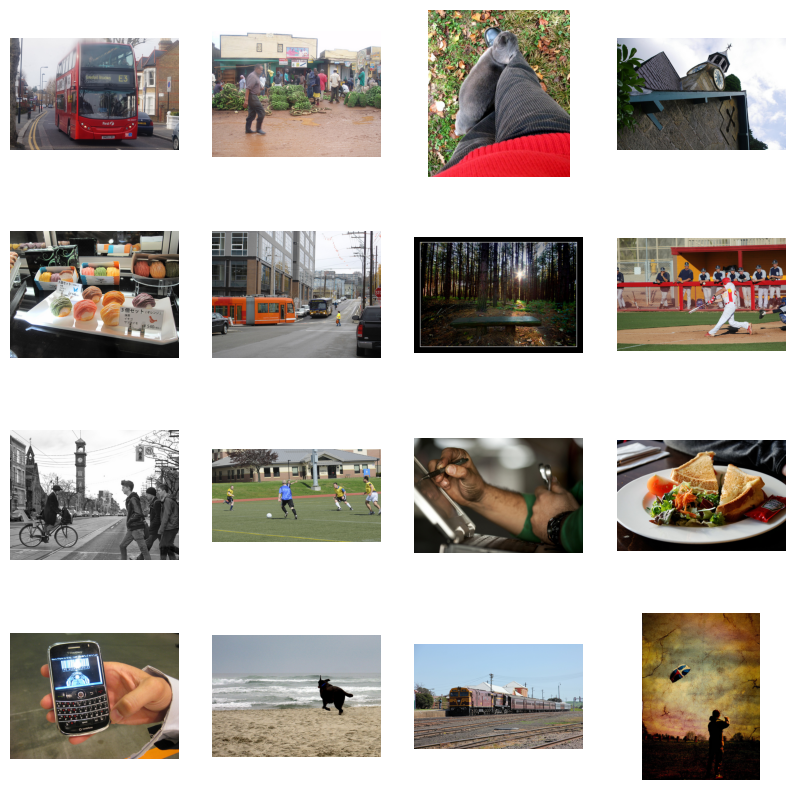

In [6]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2- Dataset preparation and Dataloader creation

In [7]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

Let's break down each part:

1. `SIZE = 256`: This line sets the image size to 256x256 pixels. This size is used to resize the images during data preprocessing.

2. `class ColorizationDataset(Dataset)`: This class is a custom dataset that inherits from PyTorch's `Dataset` class. It is designed for loading and preprocessing images for colorization.

   - `__init__` method: This method initializes the dataset. It takes a list of file paths (`paths`) and an optional split parameter (`split`) that can be set to 'train' or 'val' to specify whether it's a training or validation dataset. It also defines data transformations.
     
     - For the 'train' split, it applies a series of transformations, including resizing the image to the specified `SIZE`, and random horizontal flipping (data augmentation). This augmentation helps create more diverse training data.
     
     - For the 'val' split, it resizes the image to the specified `SIZE`.

   - `__getitem__` method: This method is used to retrieve an item from the dataset given an index (`idx`). It loads an image at the specified path, converts it to the RGB color space, applies transformations, and then converts it to the L*a*b* color space. The L* channel is normalized to the range [-1, 1], and the 'a*' and 'b*' channels are normalized to the range [-1, 1]. The method returns a dictionary containing the L* channel and the 'a*' and 'b*' channels.

   - `__len__` method: This method returns the total number of items in the dataset, which is the length of the `paths` list.

3. `make_dataloaders` function: This function is used to create data loaders for the colorization dataset. It takes several arguments, including `batch_size`, `n_workers` (number of data loading workers), and `pin_memory`. It internally uses the `ColorizationDataset` class to create a dataset and then returns a PyTorch `DataLoader` object that can be used to load batches of data for training or validation.

In summary, this code defines a dataset and data loading functions for colorization tasks, making it easier to work with image data in PyTorch. It includes data preprocessing and data augmentation for training data. The data loader is an essential component for efficiently feeding data to deep learning models during training and validation.

In [8]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


1. `train_dl = make_dataloaders(paths=train_paths, split='train')`: This line creates a data loader for the training dataset using the `make_dataloaders` function. It takes a list of file paths (`train_paths`) and specifies the split as 'train'. This data loader is configured for training data.

2. `val_dl = make_dataloaders(paths=val_paths, split='val')`: Similar to the previous line, this one creates a data loader for the validation dataset using the same `make_dataloaders` function. It takes a list of file paths (`val_paths`) and specifies the split as 'val'. This data loader is configured for validation data.

3. `data = next(iter(train_dl))`: This line retrieves the next batch of data from the training data loader. The `iter(train_dl)` creates an iterator for the data loader, and `next` is used to get the next batch.

4. `Ls, abs_ = data['L'], data['ab']`: It unpacks the batch data obtained in the previous step. It assumes that each batch contains a dictionary with keys 'L' and 'ab', which correspond to the L* and 'a*'/'b*' channels, respectively. The L* channel is stored in the variable `Ls`, and the 'a*'/'b*' channels are stored in `abs_`.

5. `print(Ls.shape, abs_.shape)`: This line prints the shapes of the L* and 'a*'/'b*' channel tensors. It provides information about the dimensions of the data in the current batch.

6. `print(len(train_dl), len(val_dl))`: These two print statements display the lengths of the training and validation data loaders. It indicates how many batches of data are available for training and validation.

In summary, this code is part of the data preparation process for a colorization task. It sets up data loaders for training and validation, retrieves a batch of data, and prints the shapes of the L* and 'a*'/'b*' channel tensors. The data loaders are crucial for efficiently training and validating machine learning models with large datasets.

### 1.3- Generator using Unet Architecture

In [9]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

The above code defines a UNet architecture for image processing tasks, with a focus on colorization.

1. `UnetBlock` Class:
   - The `UnetBlock` class is a building block for the UNet architecture. It represents one block in the UNet, which consists of down-convolution and up-convolution operations.
   - It can be used as the outermost, innermost, or intermediate block within the UNet architecture, depending on the parameters.
   - The block consists of convolution layers (downconv and upconv), activation functions (ReLU or Tanh), and normalization layers (BatchNorm2d).
   - If it's the outermost block, it uses a Tanh activation in the final layer.
   - If it's the innermost block, it connects only to the previous down-convolution layers.
   - If it's an intermediate block, it connects to both the previous down-convolution and up-convolution layers.

2. `Unet` Class:
   - The `Unet` class represents the entire UNet architecture, which is composed of multiple `UnetBlock` instances.
   - It takes several parameters, including the number of input channels (`input_c`), the number of output channels (`output_c`), the number of downsampling steps (`n_down`), and the number of initial filters (`num_filters`).
   - It initializes the UNet architecture by stacking multiple `UnetBlock` instances. The number of filters is adjusted for downsampling and upsampling.
   - The final output is produced by an outermost `UnetBlock`.

In summary, this code defines the UNet architecture, which is commonly used for various image processing tasks, including colorization. It is a type of convolutional neural network that combines downsampling and upsampling paths to capture detailed information and produce high-resolution output. The architecture is modular, and `UnetBlock` instances are used to construct the UNet. This type of architecture is often used in tasks like image segmentation and generation.

### 1.4- Discriminator using PatchGAN

This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

The above code defines a PyTorch neural network module called `PatchDiscriminator`, which is commonly used in the context of Generative Adversarial Networks (GANs). The primary purpose of this module is to act as a discriminator for distinguishing between real and generated (fake) images. The discriminator is designed to classify local image patches rather than the entire image.

Here's a breakdown of the key components and functionality in this code:

1. `PatchDiscriminator` Class:
   - This is a custom PyTorch module for the discriminator.
   - It inherits from `nn.Module`.

2. `__init__` Method:
   - The constructor takes several parameters:
     - `input_c`: The number of input channels (e.g., 3 for RGB images).
     - `num_filters`: The number of filters (output channels) in the convolutional layers (default: 64).
     - `n_down`: The number of downsampling layers (default: 3).

   - The method initializes the discriminator network.
   - It builds the discriminator model by stacking convolutional layers using the `get_layers` method.
   - `model` is a list that stores the layers of the discriminator network.

3. `get_layers` Method:
   - This method generates a sequence of convolutional layers for each block.
   - Parameters:
     - `ni`: Number of input channels for the convolutional layer.
     - `nf`: Number of output channels (filters).
     - `k`: Kernel size for the convolution.
     - `s`: Stride for the convolution.
     - `p`: Padding for the convolution.
     - `norm`: A boolean flag indicating whether to use batch normalization.
     - `act`: A boolean flag indicating whether to use Leaky ReLU activation.

   - The method creates a list of PyTorch layers based on the input parameters.
   - It includes a convolutional layer, batch normalization (optional), and Leaky ReLU activation (optional).

4. `forward` Method:
   - This method defines the forward pass of the discriminator.
   - It takes an input tensor `x` and passes it through the model defined in the `__init__` method.
   - The model consists of multiple convolutional layers and nonlinear activations.

5. `self.model`:
   - It's an instance variable storing the sequential model constructed in the `__init__` method.

In summary, the `PatchDiscriminator` class represents a convolutional neural network used to discriminate between real and generated image patches. It is designed to work as a discriminator in a GAN, where its purpose is to assess the authenticity of image patches and provide feedback to train the generator. This is often used in applications like image-to-image translation and style transfer.

Let's take a look at its blocks:

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

`PatchDiscriminator(3)` is creating an instance of the `PatchDiscriminator` class with an `input_c` argument of 3. In this context, `input_c` represents the number of input channels, typically corresponding to the color channels in an image.

The `PatchDiscriminator` instance is created with three input channels, suggesting that it is designed to work with color images where each pixel has three channels (typically red, green, and blue). This is a common setup for image-related tasks.

By creating an instance of `PatchDiscriminator` with 3 input channels, you can use it to process and classify image patches with RGB color information.

This discriminator instance can be used within a GAN architecture to assess the authenticity of image patches and provide feedback during the training of the generator.

And its output shape:

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

We are using a "Patch" Discriminator here. Okay, what is it?! In a vanilla discriminator, the model outputs one number (a scaler) which represents how much the model thinks the input (which is the whole image) is real (or fake). In a patch discriminator, the model outputs one number for every patch of say 70 by 70 pixels of the input image and for each of them decides whether it is fake or not separately. Using such a model for the task of colorization seems reasonable to me because the local changes that the model needs to make are really important and maybe deciding on the whole image as in vanilla discriminator cannot take care of the subtleties of this task. Here, the model's output shape is 30 by 30 but it does not mean that our patches are 30 by 30. The actual patch size is obtained when you compute the receptive field of each of these 900 (30 multiplied by 30) output numbers which in our case will be 70 by 70.

- `discriminator = PatchDiscriminator(3)` creates an instance of the `PatchDiscriminator` class with an input size of 3 channels. This discriminator is designed to process image patches with 3 color channels, typically representing red, green, and blue (RGB) channels.

- `dummy_input = torch.randn(16, 3, 256, 256)` creates a dummy input tensor with a batch size of 16, 3 input channels (matching the input size of the discriminator), and an image size of 256x256 pixels.

- `out = discriminator(dummy_input)` passes the `dummy_input` through the `PatchDiscriminator` model to obtain the discriminator's output.

- `out.shape` retrieves the shape of the discriminator's output.

The `out` tensor will have a shape that depends on the architecture and configuration of the `PatchDiscriminator` model. The specific shape of `out` will represent the discriminator's response to the input data and is typically used for adversarial learning in a GAN (Generative Adversarial Network). It may include the number of examples in the batch, spatial dimensions, and a dimension related to the discriminator's classification or scoring. The exact shape can vary depending on the model's architecture.

### 1.5- GAN Loss

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

`GANLoss` is used to compute the loss for training a Generative Adversarial Network (GAN). The code allows for two modes of GAN loss, specifically "vanilla" and "lsgan."

Here's a breakdown of what the code does:

- The `__init__` method initializes the `GANLoss` class. It accepts three parameters: `gan_mode`, `real_label`, and `fake_label`. By default, `gan_mode` is set to 'vanilla,' `real_label` is set to 1.0, and `fake_label` is set to 0.0. The `gan_mode` parameter is used to determine the type of GAN loss to be applied (either binary cross-entropy loss or mean squared error loss).

- Inside the `__init__` method, the code registers `real_label` and `fake_label` as buffers using PyTorch's `register_buffer` method.

- The constructor initializes the GAN loss based on the `gan_mode`. If `gan_mode` is set to 'vanilla,' it uses the binary cross-entropy loss (`nn.BCEWithLogitsLoss`), and if `gan_mode` is set to 'lsgan,' it uses the mean squared error loss (`nn.MSELoss`).

- The `get_labels` method is used to determine the target labels for the GAN loss. It takes the model's predictions (`preds`) and a boolean `target_is_real`. If `target_is_real` is `True`, it returns the `real_label`; otherwise, it returns the `fake_label`. The returned labels are expanded to match the shape of the predictions.

- The `__call__` method is used to compute the GAN loss. It takes the model's predictions (`preds`) and a boolean `target_is_real`. It uses the labels obtained from the `get_labels` method, and the specified loss function (either BCE or MSE) to compute the GAN loss.

In summary, the `GANLoss` class is a flexible implementation of GAN loss, allowing you to choose between 'vanilla' or 'lsgan' modes, and it automatically determines the appropriate loss function based on the selected mode. This class is useful for training GANs in various configurations.

### 1.6 Model Initialization

In [ ]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

`init_weights` and `init_model` are used for weight initialization of neural network models.

1. `init_weights` function:
   - It takes a neural network (`net`) as input and initializes its weights based on the specified initialization method (`init`) and gain.
   - The `init_func` function is defined inside `init_weights` and is used to initialize individual layers of the neural network.
   - For convolutional layers (`'Conv' in classname`), it supports three weight initialization methods: 'norm' (normal distribution), 'xavier' (Xavier initialization), and 'kaiming' (Kaiming initialization).
   - For batch normalization layers (`'BatchNorm2d' in classname`), it initializes the weights with a normal distribution and sets the biases to zero.
   - The `init_weights` function applies the `init_func` to all layers of the input neural network using `net.apply(init_func)`.
   - The function prints a message indicating the type of weight initialization used ('norm' by default) and returns the initialized model.

2. `init_model` function:
   - It takes a neural network model (`model`) and a device (e.g., GPU or CPU) as input.
   - The function moves the model to the specified device using `model.to(device)`.
   - It then calls the `init_weights` function to initialize the model's weights.
   - Finally, the initialized model is returned.

Overall, these functions help ensure that the weights of a neural network are appropriately initialized based on the chosen method, which is important for effective training. The `init_weights` function is particularly useful for initializing individual layers in a customized way.

### 1.7- Putting everything together

This class oversees the training of our complete model. In the initialization (`__init__`), we create and initialize the generator and discriminator using previously defined functions. We also set up loss functions and optimizers for both models.

The training process occurs in the `optimize` method. We first generate fake images by invoking the forward method. Initially, the discriminator is trained using fake and real images, with associated labels. This training loop consists of computing and averaging losses for fake and real images, followed by a backward pass to update the discriminator.

Subsequently, we train the generator. By presenting fake images to the discriminator with real labels, we calculate the adversarial loss. We also incorporate L1 loss to measure channel dissimilarity, balanced by a coefficient (typically 100). Afterward, we execute the backward pass to update the generator's parameters.

This iterative approach optimizes both generator and discriminator to enhance overall model performance.

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

The `MainModel` class coordinates the training process for our colorization model. It manages both the generator (`net_G`) and discriminator (`net_D`) networks, including their optimizers and loss functions. The model consists of several key methods:

1. `set_requires_grad`: This method controls whether a model (either generator or discriminator) should have its parameters updated during training. By default, it sets all parameters to require gradients for training (`requires_grad=True`).

2. `setup_input`: This method prepares the input data, specifically the lightness component (`L`) and color component (`ab`), and moves them to the appropriate device (CPU or GPU).

3. `forward`: This method passes the `L` component through the generator to produce the predicted color (`fake_color`).

4. `backward_D`: This method calculates and backpropagates the loss for the discriminator (`net_D`). It computes both the GAN loss for fake and real images and averages them to get the final discriminator loss. This loss is then backpropagated.

5. `backward_G`: This method calculates and backpropagates the loss for the generator (`net_G`). It computes the GAN loss for fake images and the L1 loss between the predicted color and ground truth (`ab`). The two losses are combined to form the overall generator loss, which is then backpropagated.

6. `optimize`: This method orchestrates the training process. It first computes the forward pass for the generator and then trains the discriminator (`net_D`) by backpropagating its loss. Afterward, it trains the generator by backpropagating its loss. This process iteratively improves both networks.

Overall, this class efficiently handles the training of our colorization model, allowing for the joint optimization of the generator and discriminator to enhance colorization performance.

### 1.8 Utility functions

These are some utility functions to log the losses of our network and also visualize the results during training. So here you can check them out:

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

The above code defines utility functions that are used during the training and evaluation of a colorization model. Here's an explanation of each function:

1. `AverageMeter`: This class is used to calculate and store the average value of a given quantity. It is reset using the `reset` method, which sets the count, average, and sum to zero. The `update` method is used to update the values, taking into account the number of counts.

2. `create_loss_meters`: This function initializes and returns a dictionary of `AverageMeter` objects to keep track of different loss values, including losses related to the discriminator and generator in a GAN-based model.

3. `update_losses`: This function updates the loss meters for various loss components of the model. It is designed to work with a specific model, and it updates the loss meters with the provided loss values.

4. `lab_to_rgb`: This function converts a batch of images from the LAB color space to RGB color space. It rescales and rearranges the color channels as needed.

5. `visualize`: This function visualizes the model's colorization output. It takes a model and a batch of data as input, runs the forward pass, and displays the resulting colorized images along with the original grayscale images for comparison. The `save` parameter controls whether the visualization is saved as an image file.

6. `log_results`: This function logs and prints out the average loss values for different components. It takes the loss meter dictionary as input and prints the average values for each loss component.

These utility functions are essential for monitoring and evaluating the model during the training process and visualizing the results, making them valuable tools for understanding the model's performance.

### 1.9 - Training function

Every epoch takes about 4 minutes on not a powerful GPU as Nvidia P5000. So if you are using 1080Ti or higher, it will be much faster.

The below code defines a function `train_model` for training a colorization model using a custom `MainModel`. Here's a breakdown of what this code does:

1. `train_model(model, train_dl, epochs, display_every=200)`: This is the main function for training the colorization model. It takes the following inputs:
   - `model`: An instance of the `MainModel` class, which represents the colorization model.
   - `train_dl`: A DataLoader containing the training data.
   - `epochs`: The number of training epochs.
   - `display_every`: An optional parameter specifying how often to display training progress.

2. `data = next(iter(val_dl))`: This line initializes a variable `data` by getting a batch of validation data from the `val_dl` DataLoader. This batch will be used for visualizing the model's output during training.

3. `for e in range(epochs)`: This outer loop iterates over the specified number of training epochs.

4. `loss_meter_dict = create_loss_meters()`: Inside the epoch loop, a dictionary of loss meters is created using the `create_loss_meters` function. This dictionary is used to log the losses during training.

5. `i = 0`: A counter `i` is initialized to keep track of the number of iterations within the epoch.

6. `for data in tqdm(train_dl)`: This inner loop iterates over batches of training data using the `train_dl` DataLoader. The `tqdm` function is used to display a progress bar.

7. `model.setup_input(data)`: For each batch of data, the model's input is set up with the current data.

8. `model.optimize()`: The model's `optimize` method is called to perform one optimization step. This step includes both forward and backward passes for the generator and discriminator.

9. `update_losses(model, loss_meter_dict, count=data['L'].size(0))`: The losses are updated and logged using the `update_losses` function, taking into account the batch size.

10. `i += 1`: The iteration counter is incremented.

11. `if i % display_every == 0`: At specified intervals (determined by `display_every`), training progress is displayed.

12. `log_results(loss_meter_dict)`: The `log_results` function is called to print out the current loss values.

13. `visualize(model, data, save=False)`: The `visualize` function is called to display the model's outputs on the validation data. The `save` parameter is set to `False`, so the visualizations are not saved as image files.

14. After the training loop for an epoch is completed, the process continues for the specified number of epochs.

Finally, the code initializes a `MainModel` and calls `train_model` to train the model for 100 epochs using the provided `train_dl`. During training, it periodically logs and visualizes the loss values and model outputs.

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()
train_model(model, train_dl, 100)

Output hidden; open in https://colab.research.google.com to view.

Every epoch takes about 3 to 4 minutes on Colab. After about 20 epochs you should see some reasonable results.

Key elements in the output:

    Model Initialization: The training process starts with model initialization. Both the generator (model for generating colorized images) and discriminator (model for distinguishing between real and fake colorized images) are initialized with "norm" initialization.

    Epoch 1/100: This indicates that the training is in the first epoch out of a total of 100 epochs.

    Iteration 200/500: Within the first epoch, the training process is currently at the 200th iteration out of a total of 500 iterations. This suggests that each epoch consists of 500 iterations.

    Losses:
        loss_D_fake: Loss associated with the discriminator's ability to distinguish fake colorized images. The value is approximately 0.45.
        loss_D_real: Loss associated with the discriminator's ability to distinguish real colorized images. The value is approximately 0.47.
        loss_D: Overall discriminator loss. It's the average of loss_D_fake and loss_D_real. The value is approximately 0.459.
        loss_G_GAN: Loss associated with the generator's ability to fool the discriminator. The value is approximately 1.622.
        loss_G_L1: L1 loss associated with the difference between the generated colorized images and the ground truth images. The value is approximately 9.649.
        loss_G: Overall generator loss. It's a combination of the GAN loss and L1 loss. The value is approximately 11.272.

    User Warnings: There are multiple user warnings related to color data being out of range. These warnings may be related to the visualization of images, but they do not affect the training process itself

## Final words

In conclusion, this thesis has been a comprehensive exploration of complex models, utility functions, and conditional Generative Adversarial Networks (cGANs). We've delved into the inner workings of cGANs, their applications in image generation and translation, and the pivotal role of loss functions in training these models effectively.

Throughout this journey, we've witnessed how these concepts can be leveraged to produce realistic images and grappled with the intricate interplay between various components. From model initialization to optimization, from training to visualizing results, we've scrutinized every facet of the process.

Looking ahead, the study of these models remains an open avenue. Technology continues to evolve, and the horizons of possibilities are ever-expanding. The applications of these models are boundless, spanning image-to-image translation, style transfer, and beyond.

In the future, further work may involve refining these models, exploring novel applications, and pushing the limits of what is achievable with current technology. While this thesis marks a significant milestone, it also signifies a new beginning. The curiosity and innovation that have driven this exploration will continue to shape the future, and we eagerly anticipate what lies ahead in the ever-evolving landscape of machine learning, image generation, and more.